# **Basic Data Analytics**

## Objectives

* In this notebook, we will do some preliminary statistical analysis, such as a correlation study, as well as various visualizations.

## Inputs

* The input for this is the cleaned data from the last notebook, namely `'game_data_clean.csv'`.

## Outputs

* At the end, we will have various plots displaying the statistical relationship between different features of our dataset.

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [6]:
import os
home_dir = '/workspace/pp5-ml-dashboard'
csv_dir ='/workspace/pp5-ml-dashboard/outputs/datasets/clean/csv' 
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our cleaned dataset as well as some of the packages that we will be using.

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from ydata_profiling import ProfileReport
from src.utils import get_df

game_data = get_df('game_data_clean', csv_dir)


## Section 1: Profile report
We first examine a profile report based on the data.

In [8]:
game_data.head()

,season_id,team_id_home,game_id,wl_home,min,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,Day,Month,Year
0,21985,1610612737,28500005,L,240,41.0,92.0,0.0,3.0,9.0,...,40.0,21.0,11.0,7.0,17.0,19.0,100.0,25,10,1985
1,21985,1610612758,28500006,L,240,39.0,88.0,0.0,2.0,26.0,...,42.0,19.0,7.0,7.0,18.0,32.0,108.0,25,10,1985
2,21985,1610612765,28500010,W,240,39.0,88.0,0.0,1.0,40.0,...,41.0,27.0,10.0,7.0,20.0,32.0,116.0,25,10,1985
3,21985,1610612762,28500011,L,240,42.0,82.0,0.0,2.0,24.0,...,47.0,23.0,10.0,7.0,19.0,28.0,112.0,25,10,1985
4,21985,1610612744,28500008,L,240,36.0,91.0,0.0,4.0,33.0,...,44.0,26.0,11.0,3.0,22.0,40.0,119.0,25,10,1985


We are going to modify the data frame before doing any exploratory data analysis. We are going to drop metadata columns like `'game_id'`, `'team_id'`, as well as `'Day'` and `'Month'`. We will leave `'Year'` just in case something interesting shows up. We will also need to change the column `'wl_home'`.

In [9]:
game_eda = game_data.drop(labels=['game_id','min','season_id', 'team_id_home', 'team_id_away', 'Day', 'Month'], axis=1)
game_eda['home_wins'] = game_eda.apply(lambda x: 1 if x['wl_home'] == 'W' else 0, axis=1)
game_eda.drop(labels=['wl_home'], axis=1, inplace=True)


Let's look at a profile report produced by `ydata_profiling`.

In [5]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=game_eda, minimal=True)
pandas_report.to_notebook_iframe()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

It is interesting that many of the distributions have the shape of a normal distribution. Some distributions are also skewed. You will notice that there are alerts in the report about zero values. These will not bother us as some things don't happen in a game and our data set is relatively large. The fact that the `'home_wins'` column is 0 approximately 40% of the time is actually a good sign. 

Let us investigate further if any of these features are normally distributed.

In [48]:
import pingouin as pg

normality_eda = pg.normality(game_eda, method='shapiro', alpha=0.05)
print(normality_eda.query('normal == True'))
print(normality_eda['pval'].max())

Empty DataFrame
Columns: [W, pval, normal]
Index: []
3.449999549728142e-24


From this test, it is clear that these statistics are not normally distributed. However, the distributions sure looked normal. Let's look at some qq plots. We will focus on the statistics:
* attempted field goals
* defensive rebounds
* assists

* made and attempted 3-pointers
* blocks

The first group appear to be close to normal distributions and the second grouop does not.

Field goals attempted


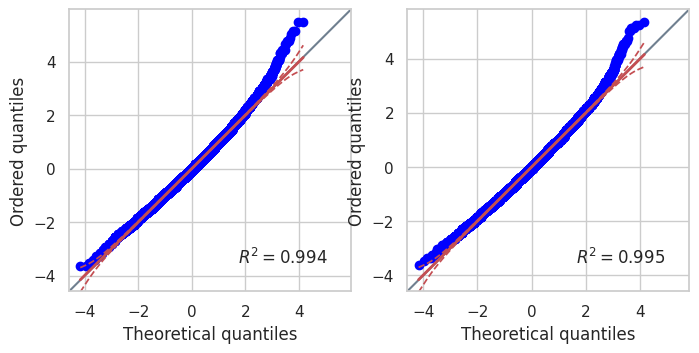

Defensive rebounds


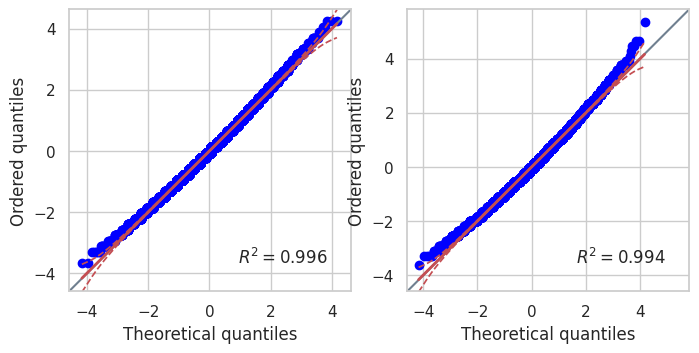

Assists


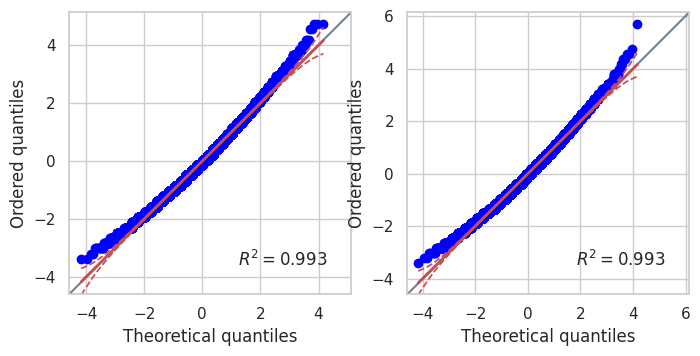

3 pointersattempted


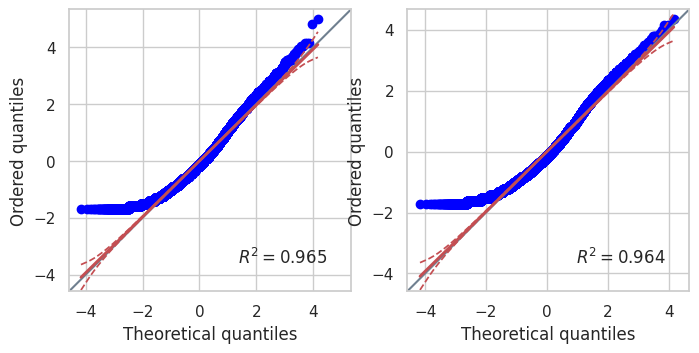

3 pointers made


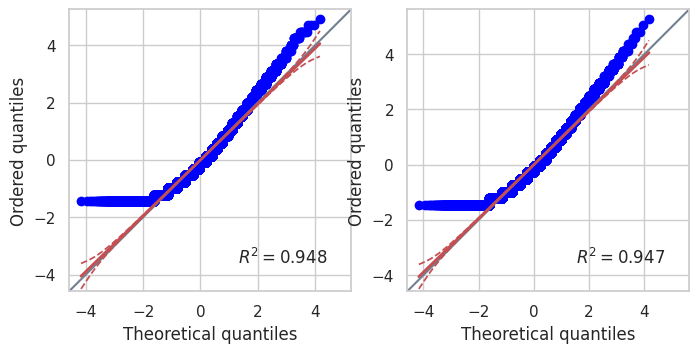

Blocks


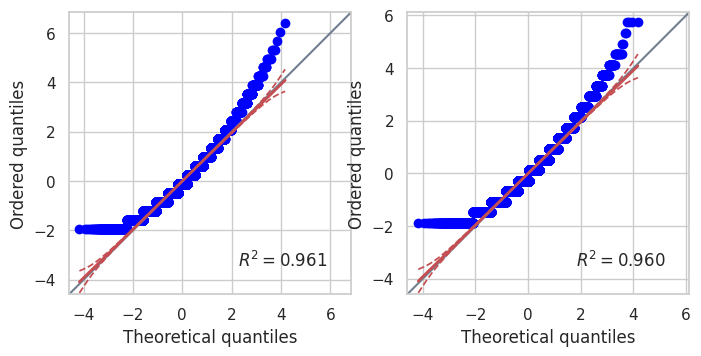

In [67]:
import pingouin as pg

good_dists = ['fga','dreb','ast']
bad_dists = ['fg3a','fg3m','blk']
translation = {'fga':'Field goals attempted','dreb':'Defensive rebounds','ast':'Assists','fg3a':'3 pointersattempted','fg3m':'3 pointers made','blk':'Blocks'}
def qq_plot_home_away(df,vars,translation):
    for var in vars:
        var_1 = var + '_home'
        var_2 = var + '_away'
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
        pg.qqplot(df[var_1], dist='norm', ax=axes[0])
        pg.qqplot(df[var_2], dist='norm', ax=axes[1])
        print(translation[var])
        plt.show()

qq_plot_home_away(game_eda,good_dists, translation)
qq_plot_home_away(game_eda,bad_dists,translation)

    

Perhaps we will be able to engineer the features a bit so that they more closely resemble normal distributions.

## Section 2: Correlation study
Now that we have a basic idea of what the distributions look like, we will focus on correlation coefficients. We will then focus on correlation with respect to the `'home_wins'`.

In [114]:
pearson_corr = game_eda.corr(method='pearson')
spearman_corr = game_eda.corr(method='spearman')
pearson_corr.head()


,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,Year,home_wins
fgm_home,1.000000,0.562736,0.138321,0.008534,-0.111305,-0.125273,0.066049,0.146351,0.163169,0.698621,...,-0.224960,-0.126408,0.207364,-0.021338,-0.088035,0.069335,-0.113838,0.407557,-0.070211,0.331596
fga_home,0.562736,1.000000,0.103396,0.171910,-0.187789,-0.198446,0.494167,0.178734,0.468299,0.297351,...,0.401317,0.349642,0.239892,-0.107578,0.252246,0.126834,-0.157285,0.422303,0.019969,-0.049170
fg3m_home,0.138321,0.103396,1.000000,0.885693,-0.228986,-0.261756,-0.282609,0.220384,-0.002866,0.138923,...,0.204325,0.041222,0.048557,-0.067192,-0.076381,-0.153228,-0.269570,0.203224,0.701095,0.077717
fg3a_home,0.008534,0.171910,0.885693,1.000000,-0.237542,-0.268588,-0.235129,0.244650,0.047954,-0.002286,...,0.372282,0.155747,0.060521,-0.075997,-0.053892,-0.147462,-0.272635,0.218207,0.797712,-0.066227
ftm_home,-0.111305,-0.187789,-0.228986,-0.237542,1.000000,0.932375,0.098260,-0.001090,0.063033,-0.067163,...,-0.174251,-0.070507,0.078779,0.025508,-0.003688,0.100106,0.765460,0.187966,-0.234412,0.189277


In [115]:
def reduce_corr_df(df_corr, threshold):
    for col in df_corr.columns:
        try:
            maxi = df_corr[col].nlargest(2)[1]
        except Exception as e:
            print(df_corr[col].nlargest(2))
            raise e
        mini = df_corr[col].min()
        #print(col,mini,maxi,threshold)
        if max(abs(maxi), abs(mini)) < threshold:
            #print('removing', col)
            df_corr.drop(col, axis=1, inplace=True)
    for row in df_corr.index:
        try:
            maxi = df_corr.loc[row].nlargest(2)[1]
        except Exception as e:
            print(df_corr.loc[row].nlargest(2))
            raise e
        mini = df_corr.loc[row].min()
        #print(row,mini,maxi,threshold)
        if max(abs(maxi), abs(mini)) < threshold:
            #print('removing', row)
            df_corr.drop(row, axis=0, inplace=True)
    return df_corr

print(pearson_corr.shape)
threshold_changes = []
for term in range(100):
    new_shape = reduce_corr_df(pearson_corr, term/100).shape
    if not threshold_changes:
        threshold_changes.append((term/100,new_shape))
    elif new_shape != threshold_changes[-1][1]:
        threshold_changes.append((term/100,new_shape))
print(threshold_changes)
'''
# This mask is gotten from the lessons on EDA
mask = np.zeros_like(pearson_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[abs(pearson_corr) < 0.4] = True

sns.heatmap(data=pearson_corr, annot=True, mask=mask, cmap='viridis', annot_kws={"size": 8}, linewidths=0.5)
plt.ylim(pearson_corr.shape[1], 0)
plt.show()
'''

(33, 33)


'threshold_changes = []\nfor term in range(100):\n    new_shape = reduce_corr_df(pearson_corr, term/100).shape\n    if not threshold_changes:\n        threshold_changes.append((term/100,new_shape))\n    elif new_shape != threshold_changes[-1][1]:\n        threshold_changes.append((term/100,new_shape))\nprint(threshold_changes)\n# This mask is gotten from the lessons on EDA\nmask = np.zeros_like(pearson_corr, dtype=np.bool)\nmask[np.triu_indices_from(mask)] = True\nmask[abs(pearson_corr) < 0.4] = True\n\nsns.heatmap(data=pearson_corr, annot=True, mask=mask, cmap=\'viridis\', annot_kws={"size": 8}, linewidths=0.5)\nplt.ylim(pearson_corr.shape[1], 0)\nplt.show()\n'

In [70]:
pearson_corr_wins = pearson_corr['home_wins'].sort_values(key=abs, ascending=False)[1:]
print(pearson_corr_wins[:11])
spearman_corr = spearman_corr['home_wins'].sort_values(key=abs, ascending=False)[1:]
print(spearman_corr[:11])


plus_minus_home    0.798495
pts_home           0.404435
pts_away          -0.386229
dreb_away         -0.343750
fgm_home           0.331596
ast_home           0.315810
dreb_home          0.307699
fgm_away          -0.299504
ast_away          -0.266257
reb_away          -0.241296
reb_home           0.239932
Name: home_wins, dtype: float64
plus_minus_home    0.846898
pts_home           0.407112
pts_away          -0.385031
dreb_away         -0.342127
fgm_home           0.331037
ast_home           0.314473
dreb_home          0.305353
fgm_away          -0.295041
ast_away          -0.260685
reb_away          -0.240049
reb_home           0.239287
Name: home_wins, dtype: float64


The `'plus_minus'` scores are the point differentials between the teams. Naturally these will correlate most strongly with winning. Similarly, `'pts'` will correlate quite strongly with winning since that is how the winner of the game is actually determined. If we trained a model on the strongest features, we would undoubtedly get a model which simply looked at the point differentials or the points scored by each team. 

We will focus on the 6 next features with that have the strongest correlation with winning. Note that both Pearson and Spearman produce the same list of features.


In [15]:
vars_to_study = list(pearson_corr[3:9].index)
vars_to_study.sort()
print(vars_to_study)

['ast_away', 'ast_home', 'dreb_away', 'dreb_home', 'fgm_away', 'fgm_home']



The following are the statistics with the least correlation with wins. It is slightly reassuring that the correlation is so weak, but it is a bit odd that it is more strongly correlated with winning than offensive rebounds.

In [12]:
print(pearson_corr[-5:])

fg3a_home   -0.066227
Year        -0.051915
fga_home    -0.049170
fg3a_away   -0.036388
oreb_home   -0.019643
Name: home_wins, dtype: float64


This tells an interesting story. Aside from points, the statistic with the highest correlation to wins is the defensive rebounds of the opposing team.

Lets look at the distribution of these statistics. We will color the histograms according two which team won. We will also look at box plots and qq plots.

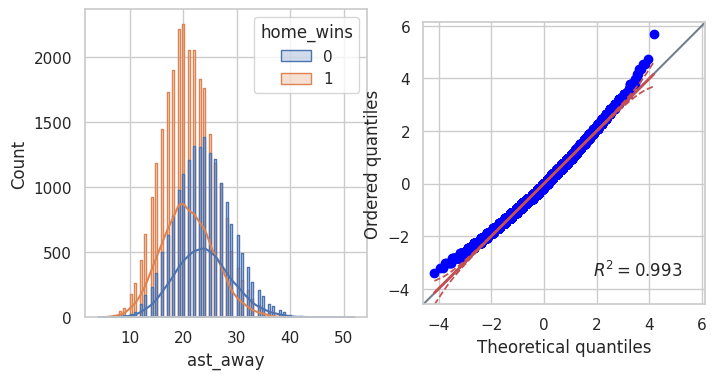

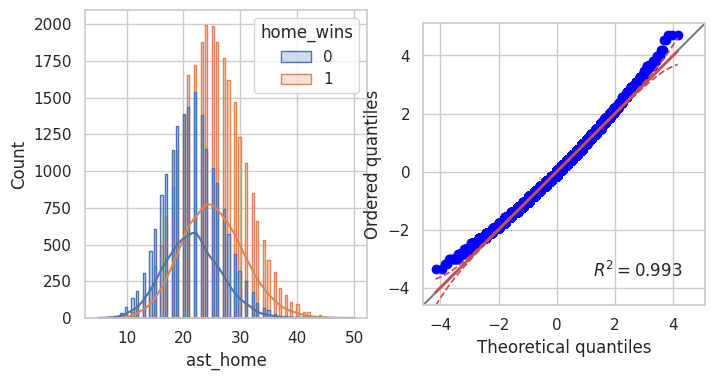

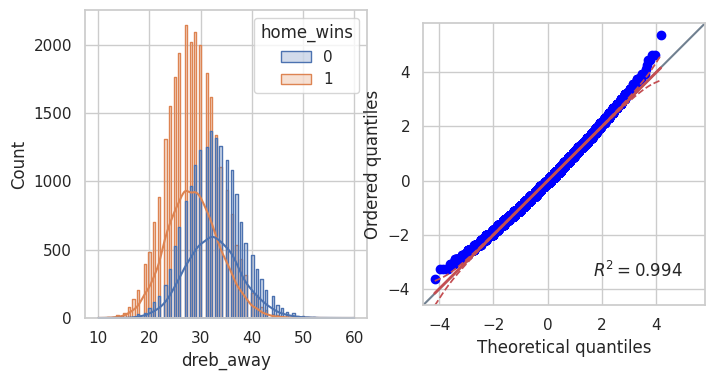

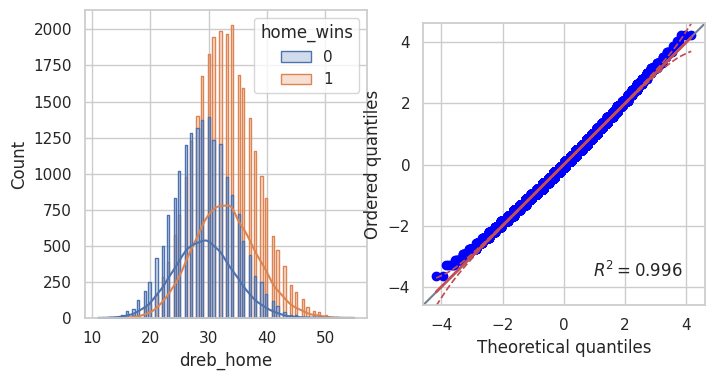

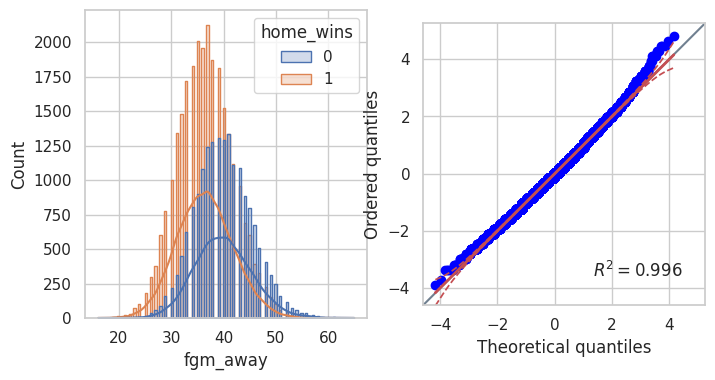

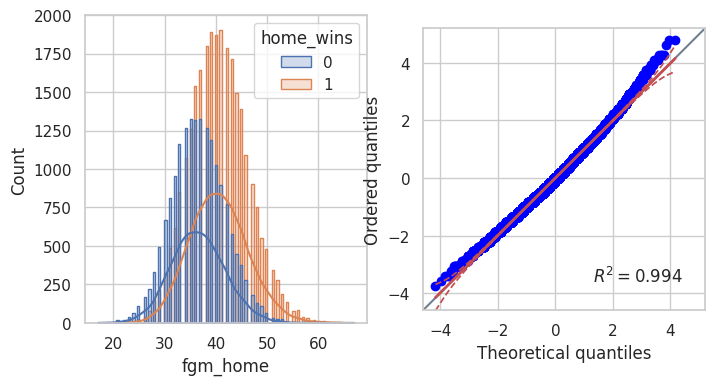

In [23]:
import pingouin as pg

for var in vars_to_study:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    sns.histplot(data=game_eda, x=var, hue='home_wins',kde=True, element="step", ax=axes[0])
    pg.qqplot(game_eda[var], dist='norm',ax=axes[1])
    plt.show()

Note the symmetry in these distributions. Swapping `'home'` to `'away'` is statistically equivalent to reflection across the y-axis. This is good. We would expect such symmetry. It is not necessarily present though as each game only appears once in our data. Further, most of these distributions have a shape similar to the normal distribution. This is also a good sign. This is also verified by the qq plots. Since the curve follows the diagonal, we know that the distributions are essentially normal.

# Section 2: Predictive Power Score
 What about Predictive Power Score? Remember, this statistic is not symmetric. It is an alternative to correlation. Perhaps it will give some insight.

In [24]:
import ppscore as pps

pps_raw = pps.matrix(df=game_eda).query('case != "predict_itself"')
pps_raw.head()


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
1,fgm_home,fga_home,0.151263,regression,True,mean absolute error,6.5432,5.553455,DecisionTreeRegressor()
2,fgm_home,fg3m_home,0.002153,regression,True,mean absolute error,3.4412,3.433790,DecisionTreeRegressor()
3,fgm_home,fg3a_home,0.000000,regression,True,mean absolute error,8.2700,8.297246,DecisionTreeRegressor()
4,fgm_home,ftm_home,0.000000,regression,True,mean absolute error,5.3258,5.358185,DecisionTreeRegressor()
5,fgm_home,fta_home,0.000000,regression,True,mean absolute error,6.5984,6.624750,DecisionTreeRegressor()


Let's look at the associated pivot table. It is large, and there are a lot of scores of 0.

In [32]:
pps_results = pps_raw.query('ppscore!=0').filter(['x', 'y', 'ppscore'])
#pps_results['ppscore'] = pps_results.apply(lambda x: round(x['ppscore'],2), axis=1)

print("mean: ",pps_results['ppscore'].mean())
print("mode: ",pps_results['ppscore'].mode())
print("median: ",pps_results['ppscore'].median())
print("standard deviation: ", pps_results['ppscore'].std())



mean:  0.06651785987939321
mode:  0      0.000059
1      0.000095
2      0.000098
3      0.000161
4      0.000174
         ...   
503    0.618887
504    0.620035
505    0.634245
506    0.634337
507    1.000000
Name: ppscore, Length: 508, dtype: float64
median:  0.020786443542002597
standard deviation:  0.12278978370207902


We are interested in predicting when the home team wins. So let's focus on that.

In [33]:
print(pps_results)
pps_wins = pps_results.query('x=="home_wins"')
pps_wins2 = pps_results.query('y=="home_wins"')
print(len(pps_wins), len(pps_wins2))
print(pps_wins)

              x          y   ppscore
1      fgm_home   fga_home  0.151263
2      fgm_home  fg3m_home  0.002153
7      fgm_home  dreb_home  0.003242
8      fgm_home   reb_home  0.006782
9      fgm_home   ast_home  0.271621
...         ...        ...       ...
1081  home_wins   ast_away  0.032722
1082  home_wins   stl_away  0.002334
1083  home_wins   blk_away  0.000161
1085  home_wins    pf_away  0.004768
1086  home_wins   pts_away  0.067250

[508 rows x 3 columns]
23 2
              x                y   ppscore
1056  home_wins         fgm_home  0.057722
1060  home_wins         ftm_home  0.008945
1061  home_wins         fta_home  0.007045
1063  home_wins        dreb_home  0.044195
1064  home_wins         reb_home  0.028010
1065  home_wins         ast_home  0.051116
1066  home_wins         stl_home  0.004236
1068  home_wins         tov_home  0.001725
1069  home_wins          pf_home  0.004791
1070  home_wins         pts_home  0.091057
1071  home_wins  plus_minus_home  0.410071
1072  home_

We want to focus on scores above a certain threshold, so to determine that threshold we plot the distribution of `'ppscore'`.

In [ ]:
sns.histplot(data=pps_results, x='ppscore', kde=True)
plt.show()

If we look at the change in the number of rows as we change the threshold we will

In [ ]:
threshold_stats = [(threshold, pps_results.query(f"ppscore>{threshold/100}").count()[0]) for threshold in range(100)]
threshold_jumps = [(threshold_stats[i][0]/100, threshold_stats[i][1],threshold_stats[i-1][1]-threshold_stats[i][1]) for i in range(1,len(threshold_stats)-1)]
print(threshold_jumps[8:])
#seems like 35 is an interesting cut off maybe.

In looking at the predictive power scores, we see a lot of obvious relationships. Relationships between plus/minus score and wins, attempted shots and made shots, made shots and wins, personal fouls and free throws. One interesting relationship is that between year and 3-point attempts. It is also interesting how little predictive power some statistics have on each other, such as field goals made and field goals attempted. There is also a surprising amount of symmetry in the statistics.

All in all, we don't feel there is a lot of insight to be gained from the `'ppscore'`. Perhaps this is because it is easy to imagine how these statistics influence each other. It is important to remember that these scores are used to try and find a relationship.

We will try 0.1 as our threshold. We will remove the first 4 rows as they involve the predictive power of `'plus_minus'` scores with respect to winning and itself (essentially). The next 8 rows correspond to the predictive power that made shots and attempted shots have with respect to each other. Next we have the relationship between made field goals and points, these are all not interesting. The relationship between year and 3-point attempts is quite interesting, but this relationship is sort of an outlier since the `'ppscore'` is comparable to that of made field goals and points, which is an obvious relationship. Similarly, the relationship between personal fouls and free throw attempts is also obvious.

In [ ]:
pps_results = pps_results.query("x!=y and ppscore>0.1")

pps_results= pps_results.sort_values(by='ppscore', ascending=False)
# print(pps_results.iloc[0:4])
print(pps_results.iloc[4:26])
pps_results.iloc[-25:]



This is a lot of data. So let's look at a heat map where we only consider correlation coefficients the top 9 correlation coefficients. Also, the `'plus_minus'` statistic is just the difference in points. So clearly, this will have the highest correlation with who wins (why is it not a correlation coefficient of 1?). The Spearman and Pearson correlation coefficients indicate the same features for further study. We may also remove the `'pts'` statistics.

In [ ]:
vars_to_study = ['ast_home','ast_away', 'dreb_away', 'dreb_home', 'fgm_away', 'fgm_home', 'pts_away', 'pts_home']
top_corr = game_data.filter(list(vars_to_study)+['home_wins'])
top_corr.head()

---

These are all numerical fields. So we will plot the distribution of the values and use hue to distinguish between wins and losses. Notice that there is a certain symmetry in the distributions. If the role of home and away are swapped we could also swap win and loss. The symmetry can also be thought of as reflecting across the y-axis. This shows a genuine symmetry in the data since each game is only listed once. The presence of the symmetry is almost reassuring and is very intuitive.

In [ ]:
for var in vars_to_study:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=game_data_for_corr, x=var, hue='home_wins', kde=True, element="step")
    plt.title(f"{var}", fontsize=20, y=1.05)
    plt.show()

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
